Import libraries

In [0]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

Load images

In [32]:
directory = '/content/drive/My Drive/NWPU-RESISC45/lake'
images = []
for file in tqdm(sorted(os.listdir(directory))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(directory + '/' + file)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images.append(image)

images = np.array(images)

Load annotations

In [0]:
data = pd.read_json('/content/labels_my-project-name_20200428035805.json')

In [0]:
data = data.transpose().reset_index()[['filename', 'regions']]

In [128]:
data.head()

,filename,regions
0,lake_001.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
1,lake_002.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
2,lake_003.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
3,lake_004.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
4,lake_005.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."


Function to plot images with annotations

In [0]:
def plot_image(i):
  #Image
  filename = data.iloc[i][0]
  image_1 = Image.open(directory + '/' + filename).convert('RGBA')

  #Polygon
  image_2 = image_1.copy()

  for shape in range(len(data['regions'][i])):
    x = data['regions'][i][str(shape)]['shape_attributes']['all_points_x']
    y = data['regions'][i][str(shape)]['shape_attributes']['all_points_y']
    coordinates = list(zip(x,y))
    draw = ImageDraw.Draw(image_2)
    draw.polygon(coordinates, fill='red')

  #Merge images
  final_image = Image.blend(image_1, image_2, alpha=0.75)
  plt.figure(figsize=(6,6))
  plt.imshow(final_image)
  plt.title(filename)
  plt.show()

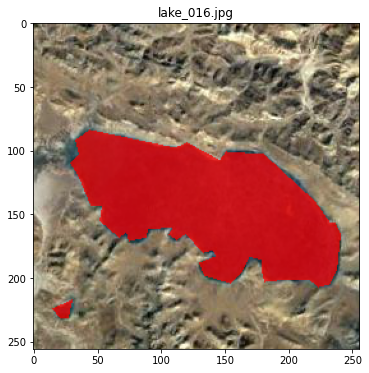

In [162]:
plot_image(15)